# Conditional Generative Adversarial Networks
Rather then just generating random samples, we can condition GAN's to some vector z by simply feeding the data, y that we wish to condition on to both the generator and discriminator. Hence, our Generator and Discriminator are now G(z,y) and D(x,y) respectively. Usually, y can be any type of additional inputs, for example, class labels.

We can see it with a probabilistic point of view. G(z,y) is modeling the distribution of our data, given z and y, that is, our data is generated with this scheme x∼G(x|z,y).

Similarly, for the Discriminator, now it tries to find discriminating label for x and xG, that are modeled with d∼D(d|x,y).

Hence, we could see that both D and G is jointly conditioned to two variable z or x and y.

Now, the objective function is given by:

$\min_G \max_D V(D, G) = \mathop{\mathbb{E}}_{x \sim p_{data}(x)} [\log D(x, y)] + \mathop{\mathbb{E}}_{z \sim p_z(z)} [\log(1 – D(G(z, y), y))]$

NOTE: See the GAN Basics notebooks before viewing this for an overview of the general structure and methods used.

In [51]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot
from tqdm import tqdm
from keras.layers import Input, Reshape, Flatten, multiply
from keras.models import Model, Sequential
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras import initializers
from scipy.interpolate import interp1d

## Load Dataset
Define class labels

In [2]:
# classes dictionary
label_dict = {0: 'tshirt',
             1: 'trouser',
             2: 'pullover',
             3: 'dress',
             4: 'coat',
             5: 'sandal',
             6: 'shirt',
             7: 'sneaker',
             8: 'bag',
             9: 'boot'}

In [3]:
def load_fashion_minst_data():
    # load the data
    (x_train, y_train), (_, _) = fashion_mnist.load_data()

    # expand to 3d, e.g. add channels dimension
    x_train = np.expand_dims(x_train, axis=-1)
    
    # normalize our inputs to be in the range[-1, 1] 
    x_train = (x_train.astype(np.float32) - 127.5)/127.5

    return x_train, y_train

 
x_train, y_train = load_fashion_minst_data()
input_classes =pd.Series(y_train).nunique()
print("x_train shape: {}".format(x_train.shape))
print("y_train.shape:{}".format(y_train.shape))
print("Input classes:{}".format(input_classes))

x_train shape: (60000, 28, 28, 1)
y_train.shape:(60000,)
Input classes:10


## Conditional Gan class

In [83]:
from keras.datasets import mnist
from keras.layers import Concatenate, Input, Dense, Reshape, Flatten, Dropout, multiply, \
    BatchNormalization, Activation, Embedding, ZeroPadding2D, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam
 
import matplotlib.pyplot as plt
import numpy as np
 
class ConditionalGAN():
    def __init__(self, in_shape=(28,28,1), n_classes=10, latent_dim=100):
        # size of the latent space
        self.in_shape = in_shape
        self.n_classes = n_classes
        self.latent_dim = latent_dim
        self.optimizer = Adam(lr=0.0002, beta_1=0.5) 
        
        # create the discriminator
        self.d_model = self.build_discriminator()
        
        # create the generator
        self.g_model = self.build_generator()
        
        # create the gan
        self.gan_model = self.build_gan(self.g_model, self.d_model)

    def build_discriminator(self, in_shape=(28,28,1), n_classes=10):
        """define the standalone discriminator model"""
        # label input
        in_label = Input(shape=(1,))
        # embedding for categorical input
        li = Embedding(self.n_classes, 50)(in_label)
        # scale up to image dimensions with linear activation
        n_nodes = in_shape[0] * in_shape[1]
        li = Dense(n_nodes)(li)
        # reshape to additional channel
        li = Reshape((in_shape[0], in_shape[1], 1))(li)
        # image input
        in_image = Input(shape=in_shape)
        # concat label as a channel
        merge = Concatenate()([in_image, li])
        # downsample
        fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
        fe = LeakyReLU(alpha=0.2)(fe)
        # downsample
        fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        # flatten feature maps
        fe = Flatten()(fe)
        # dropout
        fe = Dropout(0.4)(fe)
        # output
        out_layer = Dense(1, activation='sigmoid')(fe)
        # define model
        model = Model([in_image, in_label], out_layer)
        # compile model
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return model
    
    def build_generator(self):
        """define the standalone generator model"""
        # label input
        in_label = Input(shape=(1,))
        # embedding for categorical input
        li = Embedding(self.n_classes, 50)(in_label)
        # linear multiplication
        n_nodes = 7 * 7
        li = Dense(n_nodes)(li)
        # reshape to additional channel
        li = Reshape((7, 7, 1))(li)
        # image generator input
        in_lat = Input(shape=(self.latent_dim,))
        # foundation for 7x7 image
        n_nodes = 128 * 7 * 7
        gen = Dense(n_nodes)(in_lat)
        gen = LeakyReLU(alpha=0.2)(gen)
        gen = Reshape((7, 7, 128))(gen)
        # merge image gen and label input
        merge = Concatenate()([gen, li])
        # upsample to 14x14
        gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
        gen = LeakyReLU(alpha=0.2)(gen)
        # upsample to 28x28
        gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
        gen = LeakyReLU(alpha=0.2)(gen)
        # output
        out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
        # define model
        model = Model([in_lat, in_label], out_layer)
        return model

    def build_gan(self, g_model, d_model):
        """define the combined generator and discriminator model, for updating the generator"""
        # make weights in the discriminator not trainable
        d_model.trainable = False
        # get noise and label inputs from generator model
        gen_noise, gen_label = g_model.input
        # get image output from the generator model
        gen_output = g_model.output
        # connect image output and label input from generator as inputs to discriminator
        gan_output = d_model([gen_output, gen_label])
        # define gan model as taking noise and label and outputting a classification
        model = Model([gen_noise, gen_label], gan_output)
        # compile model
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt)
        return model  
    
    def generate_real_samples(self, X, labels, n_samples):
        """select real samples"""
        # choose random instances
        ix = np.random.randint(0, X.shape[0], n_samples)
        # select images and labels
        selected_X, selected_labels = X[ix], labels[ix]
        # generate 'real' class labels (1)
        y = np.ones((n_samples, 1))
        return [selected_X, selected_labels], y

    def generate_latent_points(self, n_samples):
        """generate points in latent space as input for the generator"""
        # generate points in the latent space
        latent_points = np.random.randn(self.latent_dim * n_samples)
        # reshape into a batch of inputs for the network
        latent_points = latent_points.reshape(n_samples, self.latent_dim)
        # generate labels
        labels = np.random.randint(0, self.n_classes, n_samples)
        return [latent_points, labels]

    def generate_generator_prediction_samples(self, n_samples):
        """use the generator to generate n fake examples"""
        # generate points in latent space
        latent_points, labels = self.generate_latent_points(n_samples)
        # predict outputs
        X = self.generator_prediction(latent_points, labels)
        # create class labels
        y = np.zeros((n_samples, 1))
        return [X, labels], y
      
    def generator_prediction(self, latent_points, labels):
        return self.g_model.predict([latent_points, labels])
    
    def train(self, X, labels, n_epochs=100, n_batch=128):
        """train the generator and discriminator"""
        bat_per_epo = int(X.shape[0] / n_batch)
        half_batch = int(n_batch / 2)
        
        # for recording metrics.
        self.g_loss_epochs = np.zeros((n_epochs * bat_per_epo, 1))
        self.d_loss1_epochs = np.zeros((n_epochs * bat_per_epo, 1))        
        self.d_loss2_epochs = np.zeros((n_epochs * bat_per_epo, 1))
        self.acc_real_epochs = np.zeros((n_epochs, 1))
        self.acc_fake_epochs = np.zeros((n_epochs, 1))
        
        # manually enumerate epochs
        for i in range(n_epochs):
            
            # enumerate batches over the training set
            for j in range(bat_per_epo):
                # update discriminator model weights on randomly selected 'real' samples
                [X_real, labels_real], y_real = self.generate_real_samples(X, labels, half_batch)
                d_loss1, _ = self.d_model.train_on_batch([X_real, labels_real], y_real)
                
                # update discriminator model weights on generated 'fake' examples
                [X_fake, labels_fake], y_fake = self.generate_generator_prediction_samples(half_batch)
                d_loss2, _ = self.d_model.train_on_batch([X_fake, labels_fake], y_fake)
                
                # prepare points in latent space as input for the generator
                [z_input, labels_input] = self.generate_latent_points(n_batch)
                # create inverted labels for the fake samples
                y_gan = np.ones((n_batch, 1))
                # update the generator via the discriminator's error
                g_loss = self.gan_model.train_on_batch([z_input, labels_input], y_gan)
                
                # summarize loss on this batch
                print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                    (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

                # record losses for later
                self.g_loss_epochs[i*bat_per_epo + j] = g_loss
                self.d_loss1_epochs[i*bat_per_epo + j] = d_loss1
                self.d_loss2_epochs[i*bat_per_epo + j] = d_loss2

            # save per epoch metrics 
            # evaluate discriminator on real examples
            n_samples = 100
            x_real, y_real = self.generate_real_samples(X, labels, n_samples)
            _, acc_real = self.d_model.evaluate(x_real, y_real, verbose=0)
            self.acc_real_epochs[i] = acc_real
            
            # evaluate discriminator on fake examples
            x_fake, y_fake = self.generate_generator_prediction_samples(n_samples)
            _, acc_fake = self.d_model.evaluate(x_fake, y_fake, verbose=0)
            self.acc_fake_epochs[i] = acc_fake
            
        # save the generator model
        self.save_model()

    def plot_gan_losses(self):
        plt.plot(self.g_loss_epochs)
        plt.plot(self.d_loss1_epochs)
        plt.plot(self.d_loss2_epochs)
        plt.title('GAN Loss Evaluation')
        plt.ylabel('')
        plt.xlabel('epoch')
        plt.legend(['Generator', 'Discriminator (real)', 'Discriminator (fake)'],loc='upper right')
        plt.show()

    def plot_discriminator_accuracies(self):
        plt.plot(self.acc_real_epochs)
        plt.plot(self.acc_fake_epochs)
        plt.title('GAN Discriminator Accuracy Evaluation')
        plt.ylabel('')
        plt.xlabel('epoch')
        plt.legend(['Discriminator (real)', 'Discriminator (fake)'],loc='upper right')
        plt.show()
        
    def save_model(self):
        """save the model"""
        self.g_model.save('g_model.h5')
        self.d_model.save('d_model.h5')
        self.gan_model.save('gan_model.h5')
       
    def load_model(self):
        """load the model"""
        self.g_model = load_model("g_model.h5")
        self.d_model = load_model("d_model.h5")
        self.gan_model = load_model("gan_model.h5")        

## Define and train the model

In [84]:
X, y = load_fashion_minst_data()

print("Input shape:", X[0].shape)

fashion_conditional_gan = ConditionalGAN(in_shape=X[0].shape, n_classes=10, latent_dim=100)

Input shape: (28, 28, 1)


In [85]:
# train model
fashion_conditional_gan.train(X, y, n_epochs=4)

C:\applications\Miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/468, d1=0.706, d2=0.694 g=0.692


C:\applications\Miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 2/468, d1=0.635, d2=0.697 g=0.690
>1, 3/468, d1=0.581, d2=0.702 g=0.685
>1, 4/468, d1=0.523, d2=0.710 g=0.677
>1, 5/468, d1=0.465, d2=0.724 g=0.664
>1, 6/468, d1=0.422, d2=0.745 g=0.648
>1, 7/468, d1=0.377, d2=0.775 g=0.629
>1, 8/468, d1=0.359, d2=0.807 g=0.615
>1, 9/468, d1=0.318, d2=0.821 g=0.622
>1, 10/468, d1=0.305, d2=0.800 g=0.664
>1, 11/468, d1=0.296, d2=0.724 g=0.738
>1, 12/468, d1=0.336, d2=0.639 g=0.840
>1, 13/468, d1=0.317, d2=0.574 g=0.949
>1, 14/468, d1=0.346, d2=0.501 g=1.034
>1, 15/468, d1=0.305, d2=0.475 g=1.045
>1, 16/468, d1=0.258, d2=0.499 g=0.981
>1, 17/468, d1=0.321, d2=0.565 g=0.855
>1, 18/468, d1=0.343, d2=0.640 g=0.753
>1, 19/468, d1=0.253, d2=0.721 g=0.677
>1, 20/468, d1=0.248, d2=0.847 g=0.582
>1, 21/468, d1=0.180, d2=0.993 g=0.508
>1, 22/468, d1=0.190, d2=1.079 g=0.476
>1, 23/468, d1=0.142, d2=1.075 g=0.508
>1, 24/468, d1=0.152, d2=0.931 g=0.611
>1, 25/468, d1=0.110, d2=0.732 g=0.798
>1, 26/468, d1=0.115, d2=0.553 g=1.052
>1, 27/468, d1=0.110, d2=0.416 g=

>1, 413/468, d1=0.661, d2=0.576 g=0.888
>1, 414/468, d1=0.686, d2=0.560 g=0.907
>1, 415/468, d1=0.599, d2=0.526 g=0.926
>1, 416/468, d1=0.679, d2=0.540 g=0.960
>1, 417/468, d1=0.608, d2=0.548 g=0.946
>1, 418/468, d1=0.639, d2=0.558 g=0.910
>1, 419/468, d1=0.613, d2=0.571 g=0.888
>1, 420/468, d1=0.617, d2=0.671 g=0.839
>1, 421/468, d1=0.701, d2=0.722 g=0.792
>1, 422/468, d1=0.713, d2=0.789 g=0.725
>1, 423/468, d1=0.647, d2=0.768 g=0.657
>1, 424/468, d1=0.682, d2=0.874 g=0.659
>1, 425/468, d1=0.615, d2=0.889 g=0.618
>1, 426/468, d1=0.707, d2=0.960 g=0.585
>1, 427/468, d1=0.730, d2=0.975 g=0.582
>1, 428/468, d1=0.704, d2=0.923 g=0.600
>1, 429/468, d1=0.733, d2=0.858 g=0.631
>1, 430/468, d1=0.716, d2=0.840 g=0.664
>1, 431/468, d1=0.733, d2=0.740 g=0.686
>1, 432/468, d1=0.694, d2=0.705 g=0.767
>1, 433/468, d1=0.713, d2=0.633 g=0.832
>1, 434/468, d1=0.718, d2=0.603 g=0.881
>1, 435/468, d1=0.689, d2=0.547 g=0.925
>1, 436/468, d1=0.701, d2=0.518 g=0.989
>1, 437/468, d1=0.712, d2=0.497 g=1.024


>2, 356/468, d1=0.672, d2=0.713 g=0.760
>2, 357/468, d1=0.646, d2=0.751 g=0.726
>2, 358/468, d1=0.665, d2=0.729 g=0.738
>2, 359/468, d1=0.601, d2=0.727 g=0.758
>2, 360/468, d1=0.657, d2=0.644 g=0.830
>2, 361/468, d1=0.619, d2=0.660 g=0.812
>2, 362/468, d1=0.647, d2=0.680 g=0.748
>2, 363/468, d1=0.573, d2=0.724 g=0.714
>2, 364/468, d1=0.669, d2=0.767 g=0.700
>2, 365/468, d1=0.660, d2=0.745 g=0.728
>2, 366/468, d1=0.691, d2=0.694 g=0.797
>2, 367/468, d1=0.671, d2=0.621 g=0.831
>2, 368/468, d1=0.646, d2=0.637 g=0.874
>2, 369/468, d1=0.673, d2=0.621 g=0.843
>2, 370/468, d1=0.664, d2=0.688 g=0.796
>2, 371/468, d1=0.640, d2=0.696 g=0.760
>2, 372/468, d1=0.673, d2=0.715 g=0.735
>2, 373/468, d1=0.645, d2=0.697 g=0.775
>2, 374/468, d1=0.661, d2=0.677 g=0.839
>2, 375/468, d1=0.629, d2=0.608 g=0.891
>2, 376/468, d1=0.653, d2=0.594 g=0.890
>2, 377/468, d1=0.647, d2=0.632 g=0.834
>2, 378/468, d1=0.645, d2=0.669 g=0.748
>2, 379/468, d1=0.638, d2=0.759 g=0.680
>2, 380/468, d1=0.649, d2=0.794 g=0.695


>3, 299/468, d1=0.642, d2=0.662 g=0.785
>3, 300/468, d1=0.657, d2=0.664 g=0.784
>3, 301/468, d1=0.655, d2=0.657 g=0.822
>3, 302/468, d1=0.649, d2=0.648 g=0.822
>3, 303/468, d1=0.671, d2=0.608 g=0.799
>3, 304/468, d1=0.680, d2=0.635 g=0.812
>3, 305/468, d1=0.702, d2=0.615 g=0.821
>3, 306/468, d1=0.681, d2=0.635 g=0.811
>3, 307/468, d1=0.662, d2=0.630 g=0.821
>3, 308/468, d1=0.647, d2=0.635 g=0.810
>3, 309/468, d1=0.680, d2=0.635 g=0.794
>3, 310/468, d1=0.677, d2=0.622 g=0.811
>3, 311/468, d1=0.669, d2=0.622 g=0.784
>3, 312/468, d1=0.652, d2=0.643 g=0.785
>3, 313/468, d1=0.662, d2=0.655 g=0.788
>3, 314/468, d1=0.641, d2=0.639 g=0.779
>3, 315/468, d1=0.612, d2=0.638 g=0.785
>3, 316/468, d1=0.670, d2=0.637 g=0.786
>3, 317/468, d1=0.615, d2=0.650 g=0.788
>3, 318/468, d1=0.645, d2=0.667 g=0.765
>3, 319/468, d1=0.616, d2=0.651 g=0.763
>3, 320/468, d1=0.609, d2=0.662 g=0.777
>3, 321/468, d1=0.630, d2=0.685 g=0.766
>3, 322/468, d1=0.641, d2=0.672 g=0.760
>3, 323/468, d1=0.640, d2=0.660 g=0.762


>4, 242/468, d1=0.638, d2=0.624 g=0.790
>4, 243/468, d1=0.687, d2=0.674 g=0.772
>4, 244/468, d1=0.688, d2=0.661 g=0.794
>4, 245/468, d1=0.634, d2=0.661 g=0.781
>4, 246/468, d1=0.623, d2=0.656 g=0.798
>4, 247/468, d1=0.669, d2=0.651 g=0.760
>4, 248/468, d1=0.615, d2=0.659 g=0.792
>4, 249/468, d1=0.681, d2=0.684 g=0.784
>4, 250/468, d1=0.644, d2=0.656 g=0.764
>4, 251/468, d1=0.642, d2=0.656 g=0.772
>4, 252/468, d1=0.655, d2=0.671 g=0.766
>4, 253/468, d1=0.678, d2=0.692 g=0.781
>4, 254/468, d1=0.662, d2=0.672 g=0.771
>4, 255/468, d1=0.642, d2=0.682 g=0.771
>4, 256/468, d1=0.655, d2=0.647 g=0.786
>4, 257/468, d1=0.680, d2=0.666 g=0.782
>4, 258/468, d1=0.694, d2=0.641 g=0.763
>4, 259/468, d1=0.692, d2=0.637 g=0.777
>4, 260/468, d1=0.644, d2=0.710 g=0.769
>4, 261/468, d1=0.657, d2=0.665 g=0.779
>4, 262/468, d1=0.680, d2=0.677 g=0.773
>4, 263/468, d1=0.666, d2=0.683 g=0.775
>4, 264/468, d1=0.670, d2=0.653 g=0.781
>4, 265/468, d1=0.660, d2=0.665 g=0.799
>4, 266/468, d1=0.670, d2=0.650 g=0.772


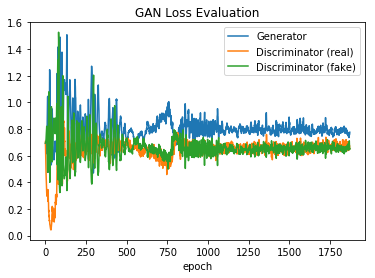

In [86]:
fashion_conditional_gan.plot_gan_losses()

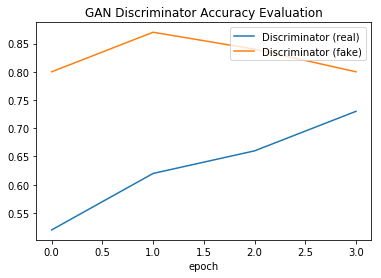

In [87]:
fashion_conditional_gan.plot_discriminator_accuracies()

## Evaluation

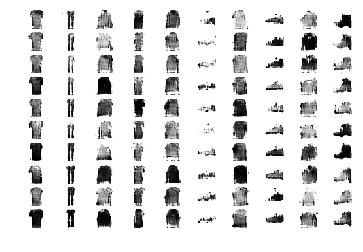

In [88]:
# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

# generate images
latent_points, _ = fashion_conditional_gan.generate_latent_points(100)
# specify labels
labels = np.asarray([x for _ in range(10) for x in range(10)])

# generate images
X = fashion_conditional_gan.generator_prediction(latent_points, labels)

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

# plot the result
save_plot(X, 10)